# 🤖 **RPA** - 📧 Mailing Automático de Reporte de Tipos de Cambio 💵

## 📚 Instalación de librerías

Para instalar correctamente los paquetes necesarios, puedes utilizar el siguiente código quitando los numerales:

In [1]:
# import sys
# !conda install --yes --prefix {sys.prefix} pandas
# !conda install --yes --prefix {sys.prefix} numpy
# !conda install --yes --prefix {sys.prefix} matplotlib
# !conda install --yes --prefix {sys.prefix} seaborn
# !conda install --yes --prefix {sys.prefix} selenium
# pip install webdriver-manager

Por otra parte, también vas a necesitar el chromedriver, o el driver necesario para tu navegador web. Este Software se descarga simplemente de la web oficial, https://chromedriver.chromium.org/. Una vez descargado, se ubica en la misma ruta que el script como es en el caso del presente notebook, o dentro del script puede informar la ruta de la siguiente manera, obviamente, quitándo los numerales que convierten las líneas de código en comentarios:

In [2]:
# ruta_webdriver = r"C:\ruta\webdriver"
# driver = webdriver.Chrome(ruta_webdriver, options=chrome_options)

## 📚 Importación de librerías

In [3]:
# Manejo del tiempo para cronometrar el programa y manejar datos tipo fecha
import time
import datetime as dt
comienzo = time.perf_counter()

# Aplicar formato fecha del español
import locale

# Manejar datos y cálculos
import pandas as pd
import numpy as np

# Webscrapping
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

# Crear gráficos
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter, FuncFormatter, MultipleLocator, AutoMinorLocator
import seaborn as sns

# No mostrar contraseña
from getpass import getpass

# Personalización del mail
import mimetypes
from email.message import EmailMessage
from email.mime.image import MIMEImage
from email.mime.base import MIMEBase
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

# Seguridad para el mailing automático
import smtplib, ssl

# Personalizar df como tabla html
from tabulate import tabulate

In [4]:
# Función para eliminar el signo peso
def eliminar_peso(x):
    return x.lstrip('$')

# Función para reemplazar la coma de un string y convertirlo a número
def reemplazar_coma(x):
    return x.str.replace(',', '.').apply(pd.to_numeric)

## 📝 Importación de Excel acumulativo 

In [5]:
ruta_bbdd = r'Seguimiento Dólar Blue.csv'
df = pd.read_csv(ruta_bbdd, index_col=0)
df

,Fecha,Solidario,TCC_Blue,TCV_Blue,TCV_MEP,TCC_Billete,TCV_Billete,TCC_Divisas,TCV_Divisas,TCC_Euro,TCV_Euro,fed_tea,bcra_tea,riesgo_pais,Solidario / TCV Blue,TCV MEP / TCV Blue,TCV Euro / TCC Blue %,Variación Solidario,Variación TCV Blue,Variación TCV Euro
0,30/08/23,639.63,730.0,740.0,675.03,347.5,365.5,349.00,350.00,793.0,804.0,5.33,209.45,2052.0,-0.135635,-0.087797,0.086486,0.0,-0.006711,-0.007407
1,29/08/23,639.63,735.0,745.0,673.72,347.5,365.5,349.00,350.00,799.0,810.0,5.33,209.45,2041.0,-0.141436,-0.095678,0.087248,0.0,0.013605,0.021438
2,28/08/23,639.63,725.0,735.0,668.95,347.5,365.5,348.95,349.95,783.0,793.0,5.33,209.45,2050.0,-0.129755,-0.089864,0.078912,0.0,0.006849,0.000000
3,25/08/23,639.63,720.0,730.0,665.14,347.5,365.5,349.10,350.10,783.0,793.0,5.33,209.45,2050.0,-0.123795,-0.088849,0.086301,0.0,0.006897,0.006345
4,24/08/23,639.63,715.0,725.0,666.34,347.5,365.5,349.00,350.00,777.0,788.0,5.33,209.45,2035.0,-0.117752,-0.080910,0.086897,0.0,-0.013605,-0.013767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6367,17/12/98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,758.0,NaN,NaN,NaN,0.0,0.000000,0.000000
6368,16/12/98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,760.0,NaN,NaN,NaN,0.0,0.000000,0.000000
6369,15/12/98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,734.0,NaN,NaN,NaN,0.0,0.000000,0.000000
6370,14/12/98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,766.0,NaN,NaN,NaN,0.0,0.000000,0.000000


## 🤖 Ingreso a la web y toma de datos 

In [6]:
# Fuentes,usaremos las variables para ingresar a las webs y para citar las fuentes
web_dolarhoy = "https://dolarhoy.com/"
web_bna = "https://www.bna.com.ar/Personas"
web_ambito_mep = "https://www.ambito.com/contenidos/dolar-mep.html"
web_ambito_riesgo_pais = "https://www.ambito.com/contenidos/riesgo-pais-historico.html"
web_fed = "https://www.federalreserve.gov/releases/h15/"
web_bcra = "https://www.bcra.gob.ar/PublicacionesEstadisticas/Principales_variables.asp"
web_tiempo_financiero = "https://tiempofinanciero.com.ar/cotizaciones/euro-blue/"

In [7]:
# Ingreso a la web dolarhoy
driver = webdriver.Chrome("chromedriver", options=chrome_options)
driver.get(web_dolarhoy)

# Toma de datos mediante xpath
solidario = driver.find_element(
    "xpath",
    '//*[@id="home_0"]/div[2]/section/div/div/div/div[1]/div/div[2]/div[6]/div/div[2]/div[2]')
blue_tcc = driver.find_element(
    "xpath",
    '//*[@id="home_0"]/div[2]/section/div/div/div/div[1]/div/div[1]/div/div[1]/div[1]/div[2]')
blue_tcv = driver.find_element(
    "xpath",
    '//*[@id="home_0"]/div[2]/section/div/div/div/div[1]/div/div[1]/div/div[1]/div[2]/div[2]')

# Creación de fila nueva, la columna fecha toma la fecha de hoy y la convierte en serie de tiempo
# - dt.timedelta(days=1) para restar un día
dolar_hoy = pd.DataFrame(
    {"Fecha":dt.datetime.today(),
     "Solidario":solidario.text,
     "TCC_Blue":blue_tcc.text,
     "TCV_Blue":blue_tcv.text},
    index=[0])

dolar_hoy["Fecha"] = pd.to_datetime(dolar_hoy["Fecha"]).dt.strftime("%d/%m/%y")

# Eliminación de $
dolar_hoy.Solidario = dolar_hoy.Solidario.apply(eliminar_peso)
dolar_hoy.TCC_Blue = dolar_hoy.TCC_Blue.apply(eliminar_peso)
dolar_hoy.TCV_Blue = dolar_hoy.TCV_Blue.apply(eliminar_peso)

display(dolar_hoy)

driver.close()

,Fecha,Solidario,TCC_Blue,TCV_Blue
0,31/08/23,639.63,720,730


In [8]:
#Ingreso a la web Banco Nación
driver = webdriver.Chrome('chromedriver', options=chrome_options)
driver.get(web_bna)

billete_tcc = driver.find_element(
    "xpath",
    '//*[@id="billetes"]/table/tbody/tr[1]/td[2]')
billete_tcv = driver.find_element(
    "xpath",
    '//*[@id="billetes"]/table/tbody/tr[1]/td[3]')

bna = pd.DataFrame({
    "TCC_Billete":billete_tcc.text,
    "TCV_Billete":billete_tcv.text},
    index=[0])

#Cliquear botón que habilita el tipo de cambio divisas
driver.find_element(
    "xpath",
    '//*[@id="rightHome"]/div[1]/div/ul/li[2]/a').click()

#Esperar dos segundos para que aparezcan los elementos, wait.until no sirvió
time.sleep(2)

bna_tcc_divisas = driver.find_element(
    "xpath",
    '//*[@id="divisas"]/table/tbody/tr[1]/td[2]')
bna_tcv_divisas = driver.find_element(
    "xpath",
    '//*[@id="divisas"]/table/tbody/tr[1]/td[3]')
bna_divisas = pd.DataFrame(
    {"TCC_Divisas":bna_tcc_divisas.text,
    "TCV_Divisas":bna_tcv_divisas.text},
    index=[0])

bna = pd.concat([bna,bna_divisas], axis = 1)

#Reemplazar la , por . para que tome los decimales, sino lo toma como string
bna = bna.apply(reemplazar_coma)

display(bna)

driver.close()

,TCC_Billete,TCV_Billete,TCC_Divisas,TCV_Divisas
0,347.5,365.5,349.0,350.0


In [9]:
driver = webdriver.Chrome('chromedriver', options=chrome_options)
driver.get(web_ambito_mep)

time.sleep(2)

mep = driver.find_element(
    "xpath",
    '/html/body/main/div/div[1]/div[1]/div/div[2]/div[1]/div/div/div[2]/span[1]')

ambito = pd.DataFrame(
    {"TCV_MEP":mep.text},
    index=[0])

driver.get(web_ambito_riesgo_pais)
time.sleep(2)

riesgo_pais = driver.find_element(
    "xpath",
    '/html/body/main/div/div[1]/div[10]/table/tbody/tr[1]/td[2]')

riesgo_pais = pd.DataFrame(
    {"riesgo_pais":riesgo_pais.text},
    index=[0])

ambito = pd.concat([ambito,riesgo_pais],axis = 1)

ambito = ambito.apply(reemplazar_coma)

display(ambito)

driver.close()

,TCV_MEP,riesgo_pais
0,672.44,2094.0


In [10]:
driver = webdriver.Chrome('chromedriver', options=chrome_options)
driver.get(web_tiempo_financiero)

time.sleep(2)

tcc_euro = driver.find_element(
    "xpath",
    '/html/body/div[2]/div/div/main/div/div/div/div/div[1]/table/tbody/tr/td[2]')

tcv_euro =  driver.find_element(
    "xpath",
    '/html/body/div[2]/div/div/main/div/div/div/div/div[1]/table/tbody/tr/td[3]')

euro = pd.DataFrame(
    {"TCC_Euro":tcc_euro.text,
    "TCV_Euro":tcv_euro.text},
    index=[0])

euro.TCC_Euro = euro.TCC_Euro.apply(eliminar_peso)
euro.TCV_Euro = euro.TCV_Euro.apply(eliminar_peso)

display(euro)

driver.close()

,TCC_Euro,TCV_Euro
0,783,793


In [11]:
# Ingresamos a la web de la FED para obtener la tasa de interés de EEUU
driver = webdriver.Chrome('chromedriver', options=chrome_options)
driver.get(web_fed)

fed_tea = driver.find_element(
    "xpath",
    '/html/body/div[3]/div[6]/table/tbody/tr[1]/td[5]')
time.sleep(2)

fed_tea = pd.DataFrame(
{"fed_tea":fed_tea.text},
index=[0])

time.sleep(2)

driver.get(web_bcra)
time.sleep(2)

# Ingresamos a la web del BCRA para obtener la tasa de interés y la inflación de Argentina 
driver = webdriver.Chrome('chromedriver', options=chrome_options)
driver.get(web_bcra)

bcra_tea = driver.find_element(
    "xpath",
    '/html/body/div/div[2]/div/div/div/div/table/tbody/tr[8]/td[3]')
time.sleep(2)

bcra_tea = pd.DataFrame(
    {"bcra_tea":bcra_tea.text},
    index=[0])

tasas = pd.concat([fed_tea,bcra_tea], axis=1).apply(reemplazar_coma)
inflacion_mensual = driver.find_element(
        "xpath", "/html/body/div/div[2]/div/div/div/div/table/tbody/tr[39]/td[1]/a"
)
inflacion_mensual.click()

filtro_fecha_inicio = driver.find_element(
        "xpath", "/html/body/div/div[2]/div/div[2]/div/div/form/input[1]"
)
filtro_fecha_inicio

filtro_fecha_inicio.send_keys("31/01/2004")

# Fecha máxima
filtro_fecha_fin = driver.find_element(
        "xpath", "/html/body/div/div[2]/div/div[2]/div/div/form/input[2]"
)
filtro_fecha_fin

filtro_fecha_fin.send_keys("31-07-2023")

time.sleep(2)

# Click en consultar
boton_filtrar = WebDriverWait(driver, 10).until(
    EC.presence_of_element_located(
        ("xpath", "/html/body/div/div[2]/div/div[2]/div/div/form/button")
    )
)
driver.execute_script("arguments[0].click();", boton_filtrar)

time.sleep(2)

# Tomamos el contenido HTML de la tabla
tabla = driver.find_element(
    "xpath", "/html/body/div/div[2]/div/div[2]/div/div/table"
)
tabla = tabla.get_attribute("outerHTML")

# Como en Argentina usamos la , en vez del . como Python, entonces los datos vienen mal de por sí
# Lo corregimos agregando que el separador de miles de la tabla sea , y no .
inflacion_df = pd.read_html(tabla, thousands='.', decimal=',')[0]

driver.close()

print(tasas,inflacion_df)

   fed_tea  bcra_tea
0     5.33    209.45           Fecha  Valor
0    31/01/2004    0.4
1    29/02/2004    0.1
2    31/03/2004    0.6
3    30/04/2004    0.9
4    31/05/2004    0.7
..          ...    ...
230  31/03/2023    7.7
231  30/04/2023    8.4
232  31/05/2023    7.8
233  30/06/2023    6.0
234  31/07/2023    6.3

[235 rows x 2 columns]


In [12]:
#Manipulación de la Inflación
inflacion_df = inflacion_df.rename(columns = {"Valor":"Inflación"})
#Convertimos la primer columna a mm/yyyy
locale.setlocale(locale.LC_TIME, 'es_ES.utf8')
#Especificamos el formato de entrada, para después editarlo
inflacion_df['Fecha'] = pd.to_datetime(inflacion_df['Fecha'], format='%d/%m/%Y')
#Editamos el formato de las fechas, no tiene sentido tener el último día del mes
inflacion_df.Fecha = pd.to_datetime(inflacion_df.Fecha).dt.strftime('%m/%y')
#Convertimos la Fecha en índice
# inflacion_df.set_index('Fecha', inplace=True)
#A la columna inflación la dividimos por 100 para que sea %, le sumamos 1 para poder multiplicar
#Le aplicamos cumprod (multiplica acumuladamente) y le restamos el uno que sumamos para cada fila
#Lo multiplicamos por 100 para que coincida con el formato del eje Y de antes
inflacion_df["Inflación Agregada"] = ((inflacion_df["Inflación"]/100+1).cumprod()-1)*100
inflacion_df

inflacion_df.to_excel("inflacion_df.xlsx")

In [13]:
#nueva fila final con todos los datos tomados
fila_nueva = [dolar_hoy, ambito, bna, euro, tasas]
fila_nueva = pd.concat(fila_nueva, axis=1)
fila_nueva_cols = [
    'Fecha',
    'Solidario',
    'TCC_Blue',
    'TCV_Blue',
    'TCV_MEP',
    'TCC_Billete',
    'TCV_Billete',
    'TCC_Divisas',
    'TCV_Divisas',
    'TCC_Euro',
    'TCV_Euro',
    'fed_tea',
    'bcra_tea',
    'riesgo_pais'
]

fila_nueva = fila_nueva[fila_nueva_cols]
fila_nueva

,Fecha,Solidario,TCC_Blue,TCV_Blue,TCV_MEP,TCC_Billete,TCV_Billete,TCC_Divisas,TCV_Divisas,TCC_Euro,TCV_Euro,fed_tea,bcra_tea,riesgo_pais
0,31/08/23,639.63,720,730,672.44,347.5,365.5,349.0,350.0,783,793,5.33,209.45,2094.0


## 🖥️ Concatenado de la nueva fila en el DataFrame acumulado 

In [14]:
# Concatenado de la fila nueva
df = pd.concat([
    fila_nueva,
    df.loc[:]
]).reset_index(drop=True)

In [15]:
# Pasar todo a número, ya que el tipo de dato al haber tenido un signo $ no es un número
df[[
    "TCC_Blue",
    "TCV_Blue",
    "Solidario",
    "TCV_MEP",
    "TCC_Billete",
    "TCV_Billete",
    "TCV_Divisas",
    "TCC_Euro",
    "TCV_Euro"
    ]
] = df[[
    "TCC_Blue",
    "TCV_Blue",
    "Solidario",
    "TCV_MEP",
    "TCC_Billete",
    "TCV_Billete",
    "TCV_Divisas",
    "TCC_Euro",
    "TCV_Euro"
    ]
].astype(float)

In [16]:
# Bajo paridad de tasas de interés de Irving Fisher
bcra_tea_numerador = 1 + (float(df["bcra_tea"].iloc[0])/100)
fed_tea_denominador = 1 + (float(df["fed_tea"].iloc[0])/100)
division = bcra_tea_numerador / fed_tea_denominador
fwd_oficial = float(df["TCV_Billete"].iloc[0]) * division
fwd_blue = float(df["TCV_Blue"].iloc[0]) * division

In [17]:
# Crear columnas de cálculo de brechas y variación del día
df["Solidario / TCV Blue"] = df["Solidario"]/df["TCV_Blue"]-1
df["TCV MEP / TCV Blue"] = df["TCV_MEP"]/df["TCV_Blue"]-1
df["TCV Euro / TCC Blue %"] = df["TCV_Euro"]/df["TCV_Blue"]-1
df["Variación Solidario"] = df["Solidario"].pct_change(periods=-1)
df["Variación Solidario"].fillna(0, inplace=True)
df["Variación TCV Blue"] = df["TCV_Blue"].pct_change(periods=-1)
df["Variación TCV Blue"].fillna(0, inplace=True)
df["Variación TCV Euro"] = df["TCV_Euro"].pct_change(periods=-1)
df["Variación TCV Euro"].fillna(0, inplace=True)

# Eliminación de duplicados, por si se usa dos veces el mismo día no duplique datos
df = df.drop_duplicates(
    subset="Fecha",
    keep="last",
    inplace=False,
    ignore_index=False
)

# Formateo el despliegue para que me traiga % y 2 decimales, de manera que quede un output cool
planilla = df.head(10).style.format(
    {"Solidario": "{:.2f}",
     "TCV_MEP": "{:2}",
     "TCC_Blue": "{:.0f}",
     "TCV_Blue": "{:.0f}",
     "TCC_Billete": "{:2}",
     "TCV_Billete": "{:2}",
     "TCC_Divisas": "{:3}",
     "TCV_Divisas": "{:3}",
     "TCC_Euro": "{:.0f}",
     "TCV_Euro": "{:.0f}",
     "riesgo_pais": "{:.0f}",
     "fed_tea":"{:.2f}",
     "bcra_tea":"{:.2f}",
     "Solidario / TCV Blue": "{:.2%}",
     "TCV Euro / TCC Blue %": "{:.2%}",
     "TCV MEP / TCV Blue": "{:.2%}",
     "Variación TCV Blue": "{:.2%}",
     "Variación TCV Euro": "{:.2%}",
     "Variación Solidario": "{:.2%}"
     }
)

display(planilla)

print(f"""
💵Resumen diario🤖:

Costo comprar USD 200 blue: $ {(float(df["TCV_Blue"].iloc[0] * 200)):,.0f}
Costo comprar USD 200 oficiales con impuestos: $ {(float(df["Solidario"].iloc[0] * 200)):,.2f}
La diferencia es de: $ {(float(df["TCV_Blue"].iloc[0] * 200 - df["Solidario"].iloc[0] * 200)):,.2f}
La brecha entre solidario y blue es: {float((df["Solidario"].iloc[0] / df["TCV_Blue"].iloc[0]) * 100):.2f}%
El dólar solidario varió: {float(((df["Solidario"].iloc[0] / df["Solidario"].iloc[1] - 1) * 100)):.2f}%
El dólar blue varió: {float(((df["TCV_Blue"].iloc[0] / df["TCV_Blue"].iloc[1] - 1) * 100)):.2f}%
El dólar divisas varió: {float(((df["TCV_Divisas"].iloc[0] / df["TCV_Divisas"].iloc[1] - 1) * 100)):.2f}%
Entre euro blue y dólar blue hay una brecha de: {(1-df["TCV_Blue"].iloc[0]/df["TCV_Euro"].iloc[0])*100:.2f}%
El euro subió un: {float(((df["TCV_Euro"].iloc[0] / df["TCV_Euro"].iloc[1] - 1) * 100)):.2f}%
El riesgo país hoy es de: {(float(df["riesgo_pais"].iloc[0])):,.0f}, Argentina debe pagar un {(float(df["riesgo_pais"].iloc[0] / 100)):.2f}% por arriba de la tasa que paga Estados Unidos.
El valor futuro según paridad de tasas de interés oficial es: {fwd_oficial:,.2f}
El valor futuro según paridad de tasas de interés blue es: {fwd_blue:,.2f}""")

,Fecha,Solidario,TCC_Blue,TCV_Blue,TCV_MEP,TCC_Billete,TCV_Billete,TCC_Divisas,TCV_Divisas,TCC_Euro,TCV_Euro,fed_tea,bcra_tea,riesgo_pais,Solidario / TCV Blue,TCV MEP / TCV Blue,TCV Euro / TCC Blue %,Variación Solidario,Variación TCV Blue,Variación TCV Euro
0,31/08/23,639.63,720,730,672.44,347.5,365.5,349.0,350.0,783,793,5.33,209.45,2094,-12.38%,-7.88%,8.63%,0.00%,-1.35%,-1.37%
1,30/08/23,639.63,730,740,675.03,347.5,365.5,349.0,350.0,793,804,5.33,209.45,2052,-13.56%,-8.78%,8.65%,0.00%,-0.67%,-0.74%
2,29/08/23,639.63,735,745,673.72,347.5,365.5,349.0,350.0,799,810,5.33,209.45,2041,-14.14%,-9.57%,8.72%,0.00%,1.36%,2.14%
3,28/08/23,639.63,725,735,668.95,347.5,365.5,348.95,349.95,783,793,5.33,209.45,2050,-12.98%,-8.99%,7.89%,0.00%,0.68%,0.00%
4,25/08/23,639.63,720,730,665.14,347.5,365.5,349.1,350.1,783,793,5.33,209.45,2050,-12.38%,-8.88%,8.63%,0.00%,0.69%,0.63%
5,24/08/23,639.63,715,725,666.34,347.5,365.5,349.0,350.0,777,788,5.33,209.45,2035,-11.78%,-8.09%,8.69%,0.00%,-1.36%,-1.38%
6,23/08/23,639.63,725,735,664.47,347.5,365.5,348.95,349.95,788,799,5.33,209.45,2049,-12.98%,-9.60%,8.71%,0.00%,1.10%,1.14%
7,22/08/23,639.63,717,727,658.88,347.5,365.5,348.95,349.95,779,790,5.33,209.45,2128,-12.02%,-9.37%,8.67%,0.00%,0.97%,-1.13%
8,18/08/23,639.63,710,720,658.97,347.5,365.5,348.95,349.95,788,799,5.33,209.45,2185,-11.16%,-8.48%,10.97%,0.00%,-4.64%,-3.27%
9,17/08/23,639.63,745,755,659.22,347.5,365.5,348.95,349.95,815,826,5.33,209.45,2187,-15.28%,-12.69%,9.40%,0.00%,-3.21%,-2.59%



💵Resumen diario🤖:

Costo comprar USD 200 blue: $ 146,000
Costo comprar USD 200 oficiales con impuestos: $ 127,926.00
La diferencia es de: $ 18,074.00
La brecha entre solidario y blue es: 87.62%
El dólar solidario varió: 0.00%
El dólar blue varió: -1.35%
El dólar divisas varió: 0.00%
Entre euro blue y dólar blue hay una brecha de: 7.94%
El euro subió un: -1.37%
El riesgo país hoy es de: 2,094, Argentina debe pagar un 20.94% por arriba de la tasa que paga Estados Unidos.
El valor futuro según paridad de tasas de interés oficial es: 1,073.81
El valor futuro según paridad de tasas de interés blue es: 2,144.67


## 💾 Exportar a CSV

In [18]:
df.to_csv(ruta_bbdd)

## 📈 Gráficos para adjuntar en el mail

In [19]:
# Tomamos las primeras filas que querramos mostrar y las primeras 14 columnas, es decir, sin variaciones
cotizaciones_a_mostrar = 25
# Copia del dataframe, para no reemplazarlo
data = df.copy()
# Damos vuelta el dataframe sólo para los gráficos
# Si no lo damos vuelta, los gráficos van a empzar de hoy hacia atrás
data = data.iloc[::-1]
data

,Fecha,Solidario,TCC_Blue,TCV_Blue,TCV_MEP,TCC_Billete,TCV_Billete,TCC_Divisas,TCV_Divisas,TCC_Euro,TCV_Euro,fed_tea,bcra_tea,riesgo_pais,Solidario / TCV Blue,TCV MEP / TCV Blue,TCV Euro / TCC Blue %,Variación Solidario,Variación TCV Blue,Variación TCV Euro
6372,11/12/98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,720.0,NaN,NaN,NaN,0.0,0.000000,0.000000
6371,14/12/98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,766.0,NaN,NaN,NaN,0.0,0.000000,0.000000
6370,15/12/98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,734.0,NaN,NaN,NaN,0.0,0.000000,0.000000
6369,16/12/98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,760.0,NaN,NaN,NaN,0.0,0.000000,0.000000
6368,17/12/98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,758.0,NaN,NaN,NaN,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,25/08/23,639.63,720.0,730.0,665.14,347.5,365.5,349.10,350.10,783.0,793.0,5.33,209.45,2050.0,-0.123795,-0.088849,0.086301,0.0,0.006897,0.006345
3,28/08/23,639.63,725.0,735.0,668.95,347.5,365.5,348.95,349.95,783.0,793.0,5.33,209.45,2050.0,-0.129755,-0.089864,0.078912,0.0,0.006849,0.000000
2,29/08/23,639.63,735.0,745.0,673.72,347.5,365.5,349.00,350.00,799.0,810.0,5.33,209.45,2041.0,-0.141436,-0.095678,0.087248,0.0,0.013605,0.021438
1,30/08/23,639.63,730.0,740.0,675.03,347.5,365.5,349.00,350.00,793.0,804.0,5.33,209.45,2052.0,-0.135635,-0.087797,0.086486,0.0,-0.006711,-0.007407


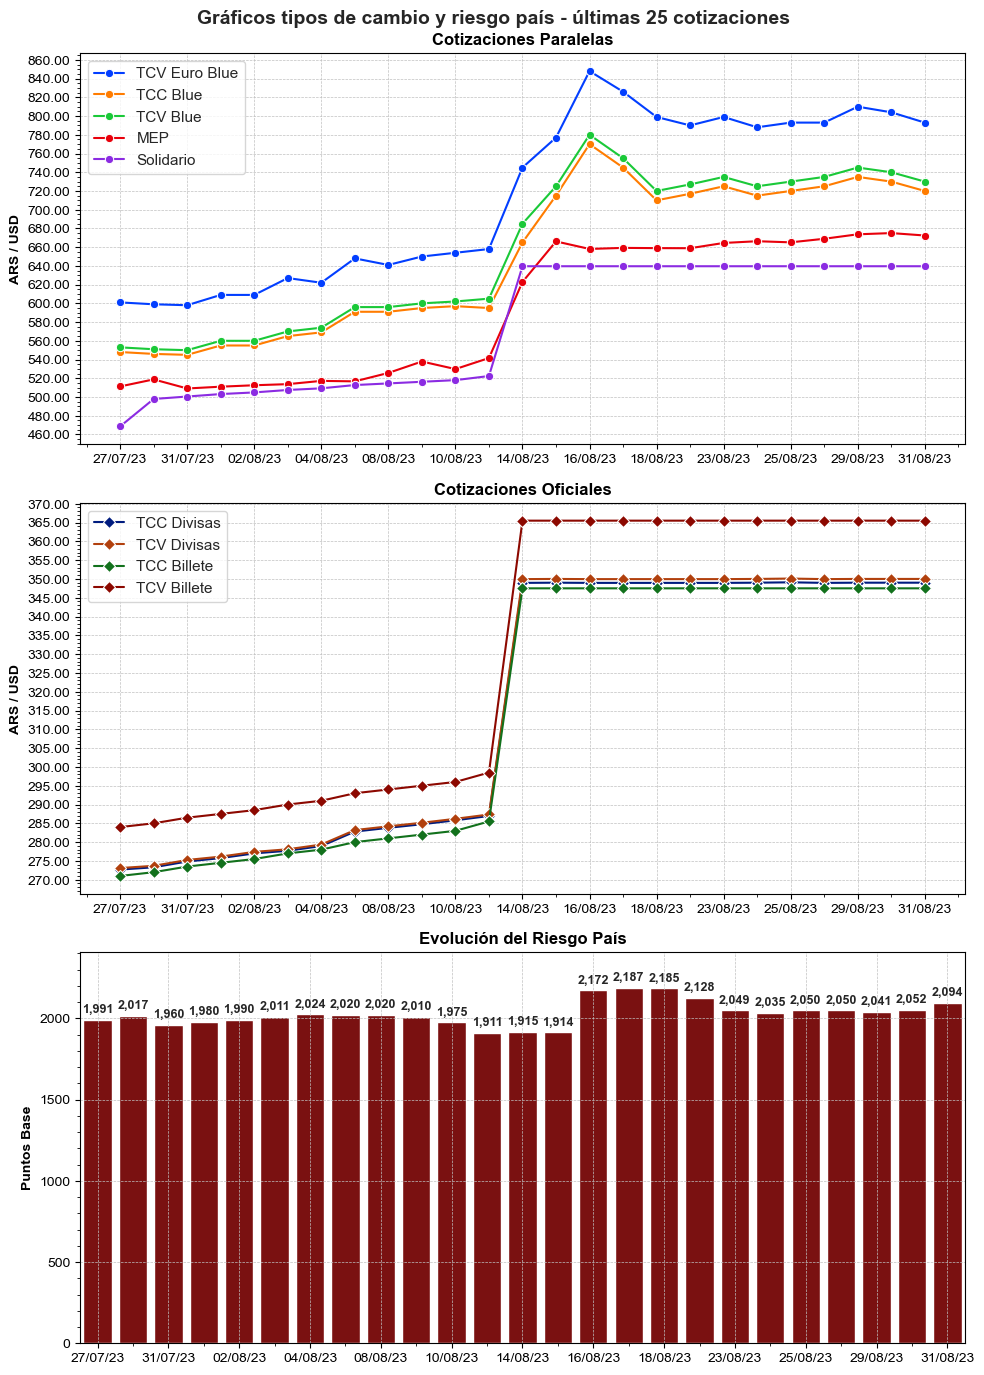

In [20]:
# Creo un subplot de 3 gráficos verticales
fig, ax = plt.subplots(
    3, 1,
    figsize=(10, 14),
    sharex=False
)

# Estilo de gráfico, con ticks en X e Y
sns.set(style="ticks")

titulos = [
    "Cotizaciones Paralelas",
    "Cotizaciones Oficiales",
    "Evolución del Riesgo País",
]

ax0_palette = sns.color_palette("bright")

ax0_columns = [
    "TCV_Euro",
    "TCC_Blue",
    "TCV_Blue",
    "TCV_MEP",
    "Solidario"
]
ax0_labels = [
    "TCV Euro Blue",
    "TCC Blue",
    "TCV Blue",
    "MEP",
    "Solidario"
]

# Títulos general y para cada gráfico
fig.suptitle(
    f"Gráficos tipos de cambio y riesgo país - últimas {cotizaciones_a_mostrar} cotizaciones",
    fontweight="bold",
    fontsize=14
)
for i, titulo in enumerate(titulos):
    ax[i].set_title(
        titulo,
        fontweight="bold",
        fontsize=12
    )

for i, column in enumerate(ax0_columns):
    sns.lineplot(
        x="Fecha",
        y=column,
        data=data.tail(cotizaciones_a_mostrar),
        label=ax0_labels[i],
        color=ax0_palette[i],
        marker="o",
        ax=ax[0],
    )

# Gráfico de cotizaciones oficiales
ax1_palette = sns.color_palette("dark")
ax1_columns = [
    "TCC_Divisas",
    "TCV_Divisas",
    "TCC_Billete",
    "TCV_Billete"
]
ax1_labels = [
    "TCC Divisas",
    "TCV Divisas",
    "TCC Billete",
    "TCV Billete"
]
for i, column in enumerate(ax1_columns):
    sns.lineplot(
        x="Fecha",
        y=column,
        data=data.tail(cotizaciones_a_mostrar),
        label=ax1_labels[i],
        color=ax1_palette[i],
        marker="D",
        ax=ax[1],
    )

# Gráfico de barras del riesgo país
sns.barplot(
    x="Fecha",
    y="riesgo_pais",
    data=data.tail(cotizaciones_a_mostrar),
    label="Riesgo País",
    color="darkred",
    ax=ax[2],
)

# Agregamos etiquetas de datos a las barras
for i, bar in enumerate(ax[2].containers[0].get_children()[-len(data.riesgo_pais) :]):
    height = bar.get_height()
    ax[2].annotate(
        f"{height:,.0f}",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontproperties=fm.FontProperties(weight="bold", size=9),
    )

# Consolidate the formatting of x-axis
for axis in ax:
    axis.set_xlabel("")
    axis.xaxis.set_major_locator(MultipleLocator(2))
    axis.xaxis.set_minor_locator(MultipleLocator(1))

# y separador de miles, por si la inflación se va demasiado, ya estoy adelantado
for i in range(2):
    ax[i].yaxis.set_major_formatter(FuncFormatter("{:,.2f}".format))

# Títulos y ticks eje Y
y_labels = ["ARS / USD", "ARS / USD", "Puntos Base"]
y_major_locators = [
    MultipleLocator(20),
    MultipleLocator(5),
    MultipleLocator(500)
]
y_minor_locators = [
    MultipleLocator(5),
    MultipleLocator(1),
    MultipleLocator(100)
]
for i in range(3):
    ax[i].set_ylabel(y_labels[i], fontweight="bold")
    ax[i].yaxis.set_major_locator(y_major_locators[i])
    ax[i].yaxis.set_minor_locator(y_minor_locators[i])

# Límites eje Y
ax[2].set_ylim([0, data.tail(cotizaciones_a_mostrar).riesgo_pais.max() * 1.1])

# Le damos estilo al grid del fondo
grid_estilo = {"color": "silver", "linestyle": "--", "linewidth": 0.5}
for axis in ax:
    axis.grid(**grid_estilo)

# Guardamos el gráfico como imagen .jpg para enviarla por mail
fig.tight_layout(pad=1)
graficos_jpg = "Gráficos Tipos de Cambios y Riesgo País.jpg"
plt.savefig(graficos_jpg)

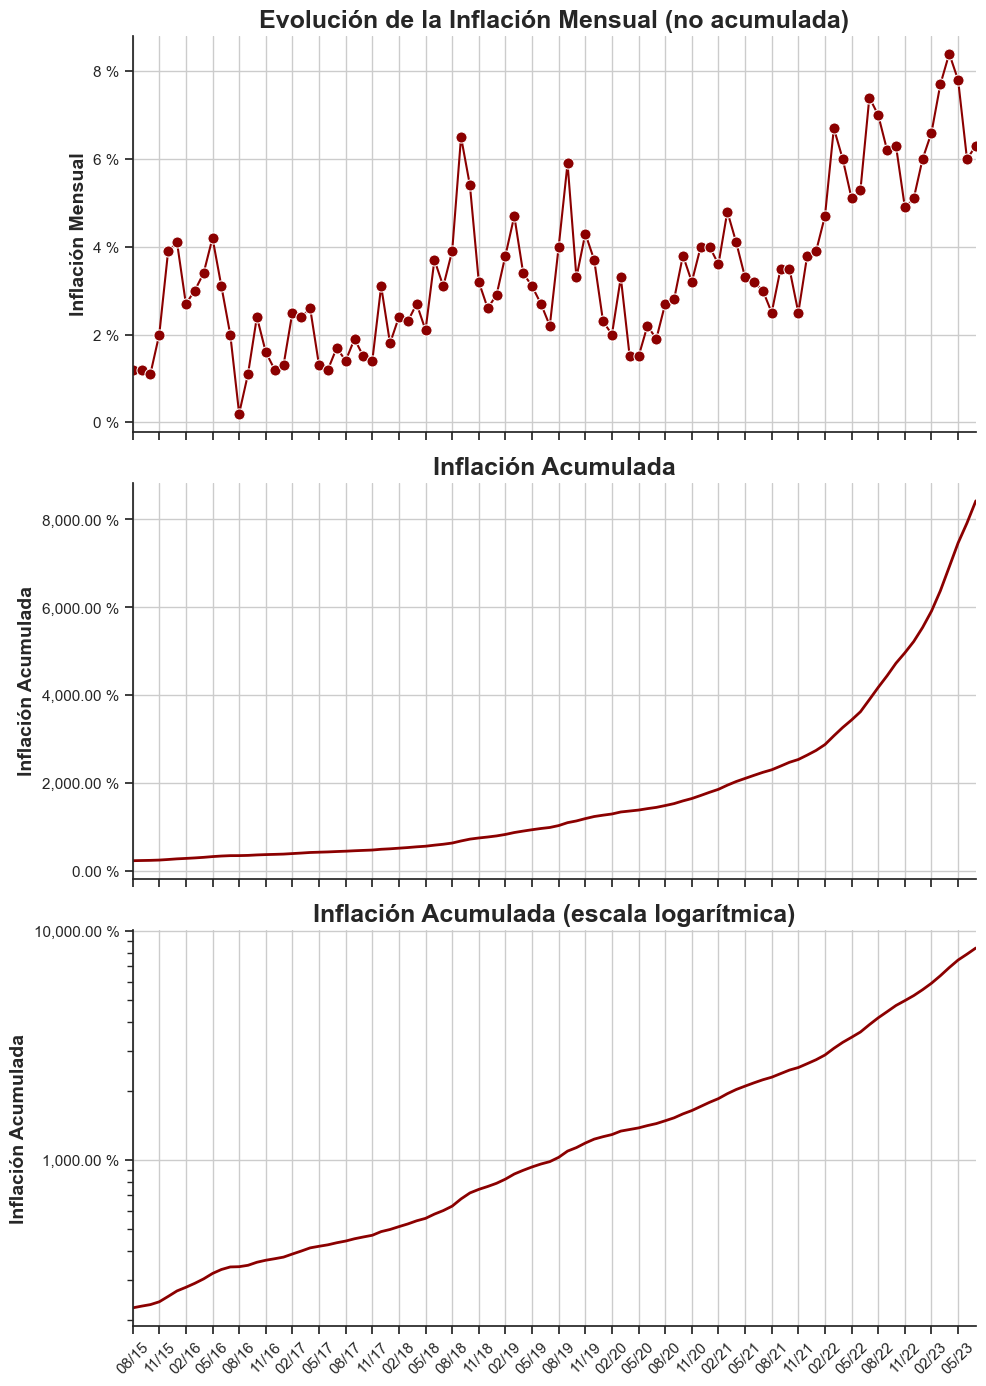

In [21]:
inflacion_df = inflacion_df.tail(96)
cantidad_filas = inflacion_df.shape[0]

# Crear un subplot con tres gráficos verticales
fig, axes = plt.subplots(3, 1, figsize=(10, 14), sharex=True)

# Gráfico inflación mensual NO ACUMULADA
sns.lineplot(
    x="Fecha",
    y="Inflación",
    data=inflacion_df,
    color="darkred",
    marker='o',
    markersize=8,
    ax=axes[0]
)

# Configurar los ticks del eje X para mostrar cada 3 meses
axes[0].set_xticks(range(0, cantidad_filas, 3))
axes[0].set_xticklabels(inflacion_df.Fecha[::3], rotation=45)
axes[0].set_xlim(0, cantidad_filas - 1)

axes[0].set_title(
    "Evolución de la Inflación Mensual (no acumulada)",
    fontweight="bold",
    fontsize=18)
axes[0].set_ylabel(
    "Inflación Mensual",
    fontweight="bold",
    fontsize=14)
axes[0].set_xlabel("")

axes[0].yaxis.set_major_formatter(FuncFormatter("{:,.0f} %".format))
axes[0].grid(True)
sns.despine()

# Gráfico inflación mensual ACUMULADA
sns.lineplot(
    x="Fecha",
    y="Inflación Agregada",
    data=inflacion_df,
    color="darkred",
    linewidth=2,
    legend=False,
    ax=axes[1]
)

# Configurar los ticks del eje X para mostrar cada 6 meses
axes[1].set_xticks(range(0, cantidad_filas, 6))
axes[1].set_xticklabels(inflacion_df.Fecha[::6], rotation=45)
axes[1].set_xlim(0, cantidad_filas - 1)

axes[1].set_title(
    "Inflación Acumulada",
    fontweight="bold",
    fontsize=18)
axes[1].set_ylabel(
    "Inflación Acumulada",
    fontweight="bold",
    fontsize=14)

axes[1].yaxis.set_major_formatter(FuncFormatter("{:,.2f} %".format))
axes[1].grid(True)
sns.despine()

# Gráfico inflación mensual ACUMULADA logarítmica
sns.lineplot(
    x="Fecha",
    y="Inflación Agregada",
    data=inflacion_df,
    color="darkred",
    linewidth=2,
    ax=axes[2]
).set_yscale("log")  # Escala logarítmica en el eje Y

# Configurar los ticks del eje X para mostrar cada 3 meses
axes[2].set_xticks(range(0, cantidad_filas, 3))
axes[2].set_xticklabels(inflacion_df.Fecha[::3], rotation=45)
axes[2].set_xlim(0, cantidad_filas - 1)
axes[2].set_xlabel("")

axes[2].set_title(
    "Inflación Acumulada (escala logarítmica)",
    fontweight="bold",
    fontsize=18)
axes[2].set_ylabel(
    "Inflación Acumulada",
    fontweight="bold",
    fontsize=14)

axes[2].yaxis.set_major_formatter(FuncFormatter("{:,.2f} %".format))
axes[2].grid(True)
sns.despine()

# Ajustar el espaciado entre los gráficos
plt.tight_layout()

# Guardamos el gráfico como imagen .jpg para enviarla por mail
fig.tight_layout(pad=1)
time.sleep(5)
inflacion_jpg = "Gráficos Inflación.jpg"
plt.savefig(inflacion_jpg)

# Mostrar el gráfico
plt.show()

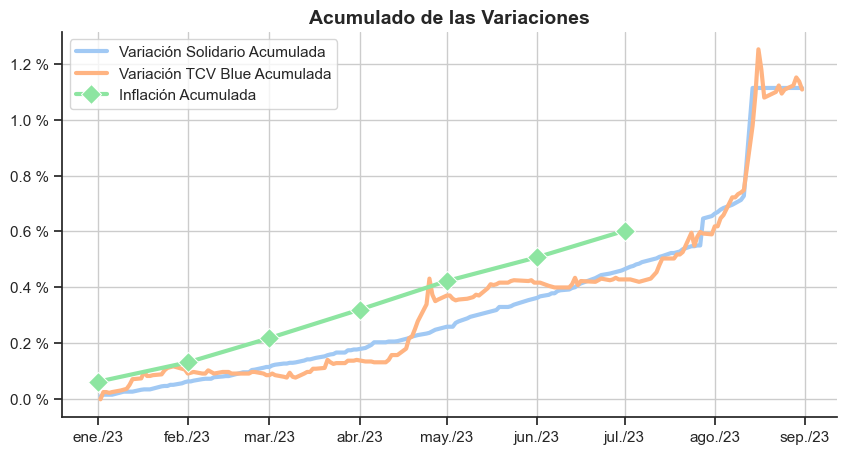

In [22]:
inflacion_df["Fecha"] = pd.to_datetime(inflacion_df["Fecha"], format="%m/%y")

data["Fecha"] = pd.to_datetime(data["Fecha"], format="%d/%m/%y")

variacion_acumulada = data.merge(inflacion_df[["Fecha","Inflación"]], on=["Fecha"], how="outer")

#Ordenamos por fecha ya que luego del merge, pone al final las fechas sin cotización pero con inflación
variacion_acumulada.sort_values("Fecha", inplace=True)

# Filtramos por el año actual
current_year = pd.Timestamp.today().year

#Damos vuelta el dataset
variacion_acumulada = variacion_acumulada[variacion_acumulada["Fecha"].dt.year == current_year]

variacion_acumulada.loc[:, "Fecha"] = pd.to_datetime(variacion_acumulada["Fecha"], format="%d-%m-%y")

#Creamos las columnas acumulativas
columns_to_cumulate = ['Variación Solidario', 'Variación TCV Blue', 'Inflación']
for column in columns_to_cumulate:
    if column == 'Inflación':
        variacion_acumulada[f'{column} Acumulada'] = (1 + variacion_acumulada[column] / 100).cumprod()-1
    else:
        variacion_acumulada[f'{column} Acumulada'] = (1 + variacion_acumulada[column]).cumprod()-1

        
cantidad_filas_variacion = len(variacion_acumulada) 
fig, ax = plt.subplots(figsize=(10, 5))

# Gráfico de cotizaciones oficiales
palette = sns.color_palette("pastel")
ax2_columns = [
    "Variación Solidario Acumulada",
    "Variación TCV Blue Acumulada",
    "Inflación Acumulada"
]
for i, column in enumerate(ax2_columns):
    if column == "Inflación Acumulada":
        sns.lineplot(
            x="Fecha",
            y=column,
            data=variacion_acumulada,
            label=ax2_columns[i],
            color=palette[i],
            linewidth=3,
            marker="D",
            markersize=10
        )
    else:
        sns.lineplot(
            x="Fecha",
            y=column,
            data=variacion_acumulada,
            label=ax2_columns[i],
            color=palette[i],
            linewidth=3
        )


ax.set_title("Acumulado de las Variaciones", fontsize=14, fontweight="bold")

import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b/%y"))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Mostrar un tick cada 3 meses
ax.yaxis.set_major_formatter(FuncFormatter("{:,.1f} %".format))

ax.set_xlabel("")
ax.set_ylabel("")

plt.grid(True)
sns.despine()

variaciones_jpg = "Variaciones.jpg"
plt.savefig(variaciones_jpg)

plt.show()

## 📮 Mailing automático

In [23]:
# Declaración de variables
email_sender = "bibybsa@gmail.com"
email_password = "wkwktaswtyneintn"
# para que funcione tu contraseña de gmail, tenés que tener una contraseña para app
# si no tenés, se crea en esta página myaccount.google.com
# email_sender = input("Tipeá tu usuario de gmail:")
# email_password = getpass("Tipeá tu contraseña:")

email_receiver = [
    "martinezmauroezequiel@gmail.com",
    "siquilacamila@gmail.com",
    "maximo.garcia@grupohst.com",
    "garciiamaximo@gmail.com",
    "fretesricardo20@gmail.com",
    "danielignacio605@gmail.com",
    "alannicolassauer@hotmail.com",
    "djacue@gmail.com",
    "rochita.sp@hotmail.com",
    "renzo.deleo@gmail.com",
    "m.cardozo@wega.com.ar",
    "facundoezequiel_andrada@hotmail.com",
    "gonzaloeorellana@gmail.com",
    "lsantanasilva@bybglobalcorp.com",
    "mariano_danze@hotmail.com",
    "duartecami28@gmail.com",
    "sscunico@gmail.com",
    "msguerrieri@bybglobalcorp.com",
    "eveiguelo@yahoo.com.ar",
    "juanmeils@hotmail.com",
    "agalean7@gmail.com",
    "apavlovsky@bybglobalcorp.com",
    "bibybsa@gmail.com",
    "mmartinez@bybglobalcorp.com"
]

# email_receiver = email_sender

# Tabular los días a mostrar del dataframe para que se vea en el cuerpo del mail
cotizaciones = [
    "Fecha",
    "Solidario",
    "tccblue",
    "tcvblue",
    "MEP",
    "tccBillete",
    "tcvBillete",
    "tccDivisas",
    "tcvDivisas",
    "tccEuros",
    "tcvEuros",
    "FEDtea",
    "BCRAtea",
    "RiesgoPaís"
]

# Valores correspondientes a los últimos días, 14 columnas
valores = df.iloc[:cotizaciones_a_mostrar, :14].values.tolist()
tabla_cotizaciones = tabulate(
    valores,
    headers=cotizaciones,
    tablefmt = "html",
    numalign="center",
    floatfmt=".2f"
)

# Encabezados para tabular últimos 10 días del df y ponerlo en el cuerpo
variaciones = [
    "Solidario/TCV_Blue",
    "MEP/TCV_Blue",
    "Euro_Blue/Dólar_Blue",
    "Variación_Solidario",
    "Variación_Blue",
    "Variación_Euro"
]
# Valores correspondientes a los últimos días, 14 columnas
valores = df.iloc[:cotizaciones_a_mostrar, 14:].values.tolist()
tabla_variaciones = tabulate(
    valores,
    headers=variaciones,
    tablefmt="html",
    numalign="center",
    floatfmt=".2%"
)

# Cuerpo del texto con código html
html = f"""<!DOCTYPE html>
<html lang="es">
   <head>
      <meta charset="UTF-8">
      <meta http-equiv="X-UA-Compatible" content="IE=edge">
      <meta name="viewport" content="width=device-width, initial-scale=1.0">
   </head>
   <body>
      <p> 📅 <b><u>Resumen diario</u></b> ℹ️<br></p>
      <p>
         <b>Costo comprar USD 200 blue 💰:</b> $ {(float(df["TCV_Blue"].iloc[0] * 200)):,.2f} <br>
         <b>Costo comprar USD 200 oficiales con impuestos:</b> $ {(float(df["Solidario"].iloc[0] * 200)):,.2f}<br>
         <b>La diferencia es de:</b> $ {(float(df["TCV_Blue"].iloc[0] * 200 - df["Solidario"].iloc[0] * 200)):,.2f}<br><br>
         <b>La brecha entre solidario y blue es:</b> {float((1 - df["Solidario"].iloc[0] / df["TCV_Blue"].iloc[0]) * 100):.2f}%<br>
         <b>El dólar solidario varió:</b> {float(((df["Solidario"].iloc[0] / df["Solidario"].iloc[1] - 1) * 100)):.2f}%<br>
         <b>El dólar blue varió 💵:</b> {float(((df["TCV_Blue"].iloc[0] / df["TCV_Blue"].iloc[1] - 1) * 100)):.2f}%<br>
         <b>El dólar divisas varió:</b> {float(((df["TCV_Divisas"].iloc[0] / df["TCV_Divisas"].iloc[1] - 1) * 100)):.2f}%<br><br>
         <b>El euro varió un 💶:</b> {float(((df["TCV_Euro"].iloc[0] / df["TCV_Euro"].iloc[1] - 1) * 100)):.2f}%<br>
         <b>Entre euro blue y dólar blue hay una brecha de:</b> {(1-df["TCV_Blue"].iloc[0]/df["TCV_Euro"].iloc[0])*100:.2f}%<br><br>
         <b>El valor del dólar oficial futuro según paridad de tasas de interés es:</b> $ {fwd_oficial:,.2f}<br>
         <b>El valor del dólar blue futuro según paridad de tasas de interés es 💸:</b> ${fwd_blue:,.2f}<br>
         <b>El riesgo país hoy es de ☣️:</b> {(float(df["riesgo_pais"].iloc[0])):,.0f}, es decir que Argentina debe pagar un {(float(df["riesgo_pais"].iloc[0] / 100)):.2f}% de sobretasa respecto a un bono del tesoro estadounidense.
      </p>
      <img src='cid:image1'>
      <img src='cid:image2'>
      <img src='cid:image3'>
      <p>Las siguientes tablas muestran las últimas {cotizaciones_a_mostrar} cotizaciones de dólares, euro, riesgo país y TEA del BCRA 🇦🇷 y TEA de la FED 🇺🇸.<br>
      Analizalas mientras te cebás unos mates 🧉:<br>
      </p>
      {tabla_cotizaciones}<br>
      {tabla_variaciones}<br>
      <p><b><u>Las fuentes consultadas fueron:</u>
      <b><br>Cotizaciones oficiales: </b>{web_bna}
      <b><br>Cotizaciones paralelas y Solidario: </b>{web_dolarhoy}
      <b><br>Cotización Dólar MEP: </b>{web_ambito_mep}
      <b><br>Riesgo País: </b>{web_ambito_riesgo_pais}
      <b><br>Cotización Euro Blue: </b>{web_tiempo_financiero}
      <b><br>Tasa Efectiva Anual EEUU: </b>{web_fed}
      <b><br>Tasa Efectiva Anual e Inflación Argentina: </b>{web_bcra}<br>
      </p>
      <p>
         🤓 Muchas gracias por leer,<br>
         🤑 Ojalá te sirva,<br><br>
      <p> 
         👨🏽‍💼 En Linkedin encontrá mi historial laboral, académico y mis aportes en datos y comercio internacional: </i><b>linkedin.com/in/mauroemartinez/</b> <br>
         👨🏽‍💻<i> Encontrá en GitHub mis proyectos. ¡Incluso este!: </i><b>https://github.com/mauroemartinez/</b> <br>
         🤖<i> Este es un mail automático creado por <b>Mauro E. Martinez</b>, comunicarse mediante correo martinezmauroezequiel@gmail.com ante cualquier duda, feedback o desuscripción.
      </p>
      </p>  
   </body>
</html>"""

# Crear el objeto MIMEMultipart y asignarle los campos
# A los receptores los ubico en Cco para que no se vean entre sí
em = MIMEMultipart('related')
em['From'] = email_sender
em["To"] = email_sender
em['Cco'] = ', '.join(email_receiver)
em["Subject"] = f"📈 Reporte automático de tipos de cambio  💱 - {dt.datetime.today():%d-%m-%Y} 📧"

# Crear el cuerpo del mensaje como un objeto MIMEText y adjuntarlo al objeto MIMEMultipart
body = MIMEText(html, 'html')
em.attach(body)

# Crear una lista con los nombres de los archivos a adjuntar
archivos_adjuntos = [graficos_jpg, inflacion_jpg, variaciones_jpg]
# Iterar a través de la lista y adjuntar cada uno
for archivo in archivos_adjuntos:
    with open(archivo, 'rb') as fp:
        msgImage = MIMEImage(fp.read())
    # Definir ID de la imagen, tal como en el html, adjuntar
    msgImage.add_header('Content-ID', f'<image{archivos_adjuntos.index(archivo) + 1}>')
    msgImage.add_header('Content-Disposition', 'attachment', filename=archivo)
    em.attach(msgImage)

# # Abrir y adjuntar el .csv
# bd_filename = 'Seguimiento Dólar Blue.csv'
# with open(bd_filename, 'r') as fp:
#     bd_data = fp.read()
# bd = MIMEText(bd_data, 'csv')
# bd.add_header('Content-Disposition', 'attachment', filename=bd_filename)
# em.attach(bd)

# Crear un contexto SSL y establecer una conexión SMTP segura con el servidor de correo
context = ssl.create_default_context()
with smtplib.SMTP_SSL(
    "smtp.gmail.com",
    465,
    context=context) as smtp:
    smtp.login(
        email_sender,
        email_password
        )
    smtp.sendmail(
        email_sender,
        email_receiver,
        em.as_string()
        )

# # para outlook
# context = ssl.create_default_context()
# with smtplib.SMTP("smtp-mail.outlook.com", 587) as server:
#     server.ehlo()
#     server.starttls(context=context)
#     server.ehlo()
#     server.login(email_sender, email_password)
#     server.sendmail(email_sender, email_receiver, em.as_string())

print(f"La duración de la ejecución total fue de: {time.perf_counter() - comienzo:.2f} segundos")

La duración de la ejecución total fue de: 151.04 segundos
